In [3]:
################## IMPORT ######################
import sys
from datetime import datetime
from functools import partial, wraps

# import fire
import jax
import jax.numpy as jnp
# import numpy as np
from jax import jit, random, value_and_grad, vmap
# from jax.experimental import optimizers
from jax.example_libraries import optimizers
from jax_md import space
from shadow.plot import *
from sklearn.metrics import r2_score
# from sympy import LM
# from torch import batch_norm_gather_stats_with_counts

from psystems.nsprings import (chain, edge_order, get_connections,
                               get_fully_connected_senders_and_receivers,
                               get_fully_edge_order)

MAINPATH = ".."  # nopep8
sys.path.append(MAINPATH)  # nopep8

import jraph
import src
from jax.config import config
from src import lnn
# from src.graph import *
# from src.lnn import acceleration, accelerationFull, accelerationTV, acceleration_GNODE
from src.md import *
from src.models import MSE, initialize_mlp, GaussianNLL, initialize_mlp_gamma
from src.nve import NVEStates, nve, BrownianStates
from src.utils import *

# config.update("jax_enable_x64", True)
# config.update("jax_debug_nans", True)
# jax.config.update('jax_platform_name', 'gpu')

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def pprint(*args, namespace=globals()):
    for arg in args:
        print(f"{namestr(arg, namespace)[0]}: {arg}")

f32 = jnp.float32
f64 = jnp.float64

In [4]:
N = 5  # number of particles
dim = 2  # dimensions
runs = 1
kT = 1 #1.380649e-23*T  # boltzmann constant*temperature
# spring_constant = 1.0
# length_constant = 1.0
# nconfig=100
seed=42
dt = 1.0e-3 # time step*stride 
lr=1e-4
batch_size=20
epochs = 10000
# node_type = jnp.array([0,0,0,0,0])
masses = jnp.ones(N)
species = jnp.zeros(N, dtype=int)
# gamma = jnp.ones(jnp.unique(species).shape)  # damping constant
datapoints = None

rname=True
withdata = None

print("Configs: ")
pprint(N, epochs, seed, rname, dt, lr, batch_size, namespace=locals())

randfilename = datetime.now().strftime("%m-%d-%Y_%H-%M-%S") + f"_{datapoints}"

PSYS = f"a-{N}-Spring-data-brownian_EM"
TAG = f"5BroGNet"
out_dir = f"../results"

def _filename(name, tag=TAG):
    rstring = randfilename if (rname and (tag != "data")) else (
        "0" if (tag == "data") or (withdata == None) else f"0_{withdata}")
    filename_prefix = f"{out_dir}/{PSYS}-{tag}/{rstring}/"
    file = f"{filename_prefix}/{name}"
    os.makedirs(os.path.dirname(file), exist_ok=True)
    filename = f"{filename_prefix}/{name}".replace("//", "/")
    print("===", filename, "===")
    return filename

def displacement(a, b):
    return a - b

def shift(R, dR):
    return R+dR

def OUT(f):
    @wraps(f)
    def func(file, *args, tag=TAG, **kwargs):
        return f(_filename(file, tag=tag), *args, **kwargs)
    return func

loadmodel = OUT(src.models.loadmodel)
savemodel = OUT(src.models.savemodel)

loadfile = OUT(src.io.loadfile)
savefile = OUT(src.io.savefile)
save_ovito = OUT(src.io.save_ovito)


Configs: 
N: 5
epochs: 10000
seed: 42
rname: True
dt: 0.001
lr: 0.0001
batch_size: 20


In [5]:
################################################
################## CONFIG ######################
################################################
np.random.seed(seed)
key = random.PRNGKey(seed)

try:
    dataset_states = loadfile(f"model_states_brownian.pkl", tag="data")[0]
except:
    raise Exception("Generate dataset first.")

model_states = dataset_states[0]

print(f"Total number of data points: {len(dataset_states)}x{model_states.position.shape[0]}")

Rs = States_Brow().fromlist(dataset_states).get_array()

if datapoints is not None:
    Rs = Rs[:datapoints]


Rs_in = Rs[:,:99,:,:]
Rs_out = Rs[:,1:100,:,:]

=== ../results/a-5-Spring-data-brownian_EM-data/0/model_states_brownian.pkl ===
Total number of data points: 100x100


In [7]:
# Copyright 2020 DeepMind Technologies Limited.


# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""A library of Graph Neural Network models."""

import functools
import sunau
from typing import Any, Callable, Iterable, Mapping, Optional, Union

import jax
import jax.numpy as jnp
from jax_md import space
import jax.tree_util as tree
from frozendict import frozendict
from jax import vmap
from jraph._src import graph as gn_graph
from jraph._src import utils

from src.models import SquarePlus, forward_pass, forward_pass_gamma, ReLU #, SoftPlus

jax.tree_util.register_pytree_node(
    frozendict,
    flatten_func=lambda s: (tuple(s.values()), tuple(s.keys())),
    unflatten_func=lambda k, xs: frozendict(zip(k, xs)))

# As of 04/2020 pytype doesn't support recursive types.
# pytype: disable=not-supported-yet
ArrayTree = Union[jnp.ndarray,
                  Iterable['ArrayTree'], Mapping[Any, 'ArrayTree']]

# All features will be an ArrayTree.
NodeFeatures = EdgeFeatures = SenderFeatures = ReceiverFeatures = Globals = ArrayTree

# Signature:
# (edges of each node to be aggregated, segment ids, number of segments) ->
# aggregated edges
AggregateEdgesToNodesFn = Callable[
    [EdgeFeatures, jnp.ndarray, int], NodeFeatures]

# Signature:
# (nodes of each graph to be aggregated, segment ids, number of segments) ->
# aggregated nodes
AggregateNodesToGlobalsFn = Callable[[NodeFeatures, jnp.ndarray, int],
                                     Globals]

# Signature:
# (edges of each graph to be aggregated, segment ids, number of segments) ->
# aggregated edges
AggregateEdgesToGlobalsFn = Callable[[EdgeFeatures, jnp.ndarray, int],
                                     Globals]

# Signature:
# (edge features, sender node features, receiver node features, globals) ->
# attention weights
AttentionLogitFn = Callable[
    [EdgeFeatures, SenderFeatures, ReceiverFeatures, Globals], ArrayTree]

# Signature:
# (edge features, weights) -> edge features for node update
AttentionReduceFn = Callable[[EdgeFeatures, ArrayTree], EdgeFeatures]

# Signature:
# (edges to be normalized, segment ids, number of segments) ->
# normalized edges
AttentionNormalizeFn = Callable[[EdgeFeatures, jnp.ndarray, int], EdgeFeatures]

# Signature:
# (edge features, sender node features, receiver node features, globals) ->
# updated edge features
GNUpdateEdgeFn = Callable[
    [EdgeFeatures, SenderFeatures, ReceiverFeatures, Globals], EdgeFeatures]

# Signature:
# (node features, outgoing edge features, incoming edge features,
#  globals) -> updated node features
GNUpdateNodeFn = Callable[
    [NodeFeatures, SenderFeatures, ReceiverFeatures, Globals], NodeFeatures]

GNUpdateGlobalFn = Callable[[NodeFeatures, EdgeFeatures, Globals], Globals]

# Signature:
# (node features, outgoing edge features, incoming edge features,
#  globals) -> updated node features
# V: Potential energy of edge
GN_to_V_Fn = Callable[[EdgeFeatures, NodeFeatures], float]
GN_to_T_Fn = Callable[[NodeFeatures], float]


def GNNet(
    V_fn: GN_to_V_Fn,
    initial_edge_embed_fn: Optional[GNUpdateEdgeFn],
    initial_node_embed_fn: Optional[GNUpdateEdgeFn],
    update_edge_fn: Optional[GNUpdateEdgeFn],
    update_node_fn: Optional[GNUpdateNodeFn],
    T_fn: GN_to_T_Fn = None,
    update_global_fn: Optional[GNUpdateGlobalFn] = None,
    aggregate_nodes_for_globals_fn: AggregateNodesToGlobalsFn = utils
    .segment_sum,
    aggregate_edges_for_globals_fn: AggregateEdgesToGlobalsFn = utils
    .segment_sum,
    attention_logit_fn: Optional[AttentionLogitFn] = None,
    attention_normalize_fn: Optional[AttentionNormalizeFn] = utils
    .segment_softmax,
        attention_reduce_fn: Optional[AttentionReduceFn] = None,
        N=1,):
    """Returns a method that applies a configured GraphNetwork.

    This implementation follows Algorithm 1 in https://arxiv.org/abs/1806.01261

    There is one difference. For the nodes update the class aggregates over the
    sender edges and receiver edges separately. This is a bit more general
    than the algorithm described in the paper. The original behaviour can be
    recovered by using only the receiver edge aggregations for the update.

    In addition this implementation supports softmax attention over incoming
    edge features.

    Example usage::

      gn = GraphNetwork(update_edge_function,
      update_node_function, **kwargs)
      # Conduct multiple rounds of message passing with the same parameters:
      for _ in range(num_message_passing_steps):
        graph = gn(graph)

    Args:
      update_edge_fn: function used to update the edges or None to deactivate edge
        updates.
      update_node_fn: function used to update the nodes or None to deactivate node
        updates.
      update_global_fn: function used to update the globals or None to deactivate
        globals updates.
      aggregate_edges_for_nodes_fn: function used to aggregate messages to each
        node.
      aggregate_nodes_for_globals_fn: function used to aggregate the nodes for the
        globals.
      aggregate_edges_for_globals_fn: function used to aggregate the edges for the
        globals.
      attention_logit_fn: function used to calculate the attention weights or
        None to deactivate attention mechanism.
      attention_normalize_fn: function used to normalize raw attention logits or
        None if attention mechanism is not active.
      attention_reduce_fn: function used to apply weights to the edge features or
        None if attention mechanism is not active.

    Returns:
      A method that applies the configured GraphNetwork.
    """
    def not_both_supplied(x, y): return (
        x != y) and ((x is None) or (y is None))
    if not_both_supplied(attention_reduce_fn, attention_logit_fn):
        raise ValueError(('attention_logit_fn and attention_reduce_fn must both be'
                          ' supplied.'))

    def _ApplyGraphNet(graph):
        """Applies a configured GraphNetwork to a graph.

        This implementation follows Algorithm 1 in https://arxiv.org/abs/1806.01261

        There is one difference. For the nodes update the class aggregates over the
        sender edges and receiver edges separately. This is a bit more general
        the algorithm described in the paper. The original behaviour can be
        recovered by using only the receiver edge aggregations for the update.

        In addition this implementation supports softmax attention over incoming
        edge features.

        Many popular Graph Neural Networks can be implemented as special cases of
        GraphNets, for more information please see the paper.

        Args:
          graph: a `GraphsTuple` containing the graph.

        Returns:
          Updated `GraphsTuple`.


        """
        # pylint: disable=g-long-lambda
        nodes, edges, receivers, senders, globals_, n_node, n_edge = graph
        # nodes, edges, receivers, senders, globals_, n_node, n_edge, _, _, _  = graph
        # nodes,edges,receivers,senders,globals_,n_node,n_edge,eorder,emask,nmask = graph
        # Equivalent to jnp.sum(n_node), but jittable

        # calculate number of nodes in graph
        sum_n_node = tree.tree_leaves(nodes)[0].shape[0]

        # calculate number of edges in graph
        sum_n_edge = senders.shape[0]
        
        # check if all all node array are of same length = number of nodes
        if not tree.tree_all(
                tree.tree_map(lambda n: n.shape[0] == sum_n_node, nodes)):
            raise ValueError(
                'All node arrays in nest must contain the same number of nodes.')

        # Initial sent info
        sent_attributes = tree.tree_map(lambda n: n[senders], nodes)

        # Initial received info
        received_attributes = tree.tree_map(lambda n: n[receivers], nodes)

        # Here we scatter the global features to the corresponding edges,
        # giving us tensors of shape [num_edges, global_feat].
        # i.e create an array per edge for global attributes
        global_edge_attributes = tree.tree_map(lambda g: jnp.repeat(
            g, n_edge, axis=0, total_repeat_length=sum_n_edge), globals_)

        # Here we scatter the global features to the corresponding nodes,
        # giving us tensors of shape [num_nodes, global_feat].
        # i.e create an array per node for global attributes
        global_attributes = tree.tree_map(lambda g: jnp.repeat(
            g, n_node, axis=0, total_repeat_length=sum_n_node), globals_)

        # apply initial edge embeddings
        if initial_edge_embed_fn:
            edges = initial_edge_embed_fn(edges, sent_attributes, received_attributes,
                                          global_edge_attributes)
        # apply initial node embeddings
        if initial_node_embed_fn:
            nodes = initial_node_embed_fn(nodes, sent_attributes,
                                          received_attributes, global_attributes)

        # Now perform message passing for N times
        for pass_i in range(N):
            if attention_logit_fn:
                logits = attention_logit_fn(edges, sent_attributes, received_attributes,
                                            global_edge_attributes)
                tree_calculate_weights = functools.partial(
                    attention_normalize_fn,
                    segment_ids=receivers,
                    num_segments=sum_n_node)
                weights = tree.tree_map(tree_calculate_weights, logits)
                edges = attention_reduce_fn(edges, weights)

            if update_node_fn:
                nodes = update_node_fn(
                    nodes, edges, senders, receivers,
                    global_attributes, sum_n_node)

            if update_edge_fn:
                senders_attributes = tree.tree_map(
                    lambda n: n[senders], nodes)
                receivers_attributes = tree.tree_map(
                    lambda n: n[receivers], nodes)
                edges = update_edge_fn(edges, senders_attributes, receivers_attributes,
                                       global_edge_attributes, pass_i == N-1)

        if update_global_fn:
            n_graph = n_node.shape[0]
            graph_idx = jnp.arange(n_graph)
            # To aggregate nodes and edges from each graph to global features,
            # we first construct tensors that map the node to the corresponding graph.
            # For example, if you have `n_node=[1,2]`, we construct the tensor
            # [0, 1, 1]. We then do the same for edges.
            node_gr_idx = jnp.repeat(
                graph_idx, n_node, axis=0, total_repeat_length=sum_n_node)
            edge_gr_idx = jnp.repeat(
                graph_idx, n_edge, axis=0, total_repeat_length=sum_n_edge)
            # We use the aggregation function to pool the nodes/edges per graph.
            node_attributes = tree.tree_map(
                lambda n: aggregate_nodes_for_globals_fn(
                    n, node_gr_idx, n_graph),
                nodes)
            edge_attribtutes = tree.tree_map(
                lambda e: aggregate_edges_for_globals_fn(
                    e, edge_gr_idx, n_graph),
                edges)
            # These pooled nodes are the inputs to the global update fn.
            globals_ = update_global_fn(
                node_attributes, edge_attribtutes, globals_)

        V = 0.0
        if V_fn is not None:
            V += V_fn(edges, nodes)

        T = 0.0
        if T_fn is not None:
            T += T_fn(nodes)

        # pylint: enable=g-long-lambda
        return gn_graph.GraphsTuple(
            nodes=nodes,
            edges=edges,
            receivers=receivers,
            senders=senders,
            globals=globals_,
            n_node=n_node,
            n_edge=n_edge), V, T

    return _ApplyGraphNet


# Signature:
# edge features -> embedded edge features
EmbedEdgeFn = Callable[[EdgeFeatures], EdgeFeatures]

# Signature:
# node features -> embedded node features
EmbedNodeFn = Callable[[NodeFeatures], NodeFeatures]

# Signature:
# globals features -> embedded globals features
EmbedGlobalFn = Callable[[Globals], Globals]


def get_fully_connected_senders_and_receivers(
    num_particles: int, self_edges: bool = False,
):
    """Returns senders and receivers for fully connected particles."""
    particle_indices = jnp.arange(num_particles)
    senders, receivers = jnp.meshgrid(particle_indices, particle_indices)
    senders, receivers = senders.flatten(), receivers.flatten()
    if not self_edges:
        mask = senders != receivers
        senders, receivers = senders[mask], receivers[mask]
    return senders, receivers


def cal_graph(params, graph, eorder=None, mpass=1,
              useT=True, useonlyedge=False, act_fn=SquarePlus):
    fb_params = params["fb"]
    fne_params = params["fne"]
    fneke_params = params["fneke"]
    fv_params = params["fv"]
    fe_params = params["fe"]
    ff1_params = params["ff1"]
    ff2_params = params["ff2"]
    ff3_params = params["ff3"]
    ke_params = params["ke"]

    num_species = 1
    
    def onehot(n):
        def fn(n):
            out = jax.nn.one_hot(n, num_species)
            return out
        out = vmap(fn)(n.reshape(-1,))
        return out

    def fne(n):
        def fn(ni):
            out = forward_pass(fne_params, ni, activation_fn=lambda x: x)
            return out
        out = vmap(fn, in_axes=(0))(n)
        return out

    def fneke(n):
        def fn(ni):
            out = forward_pass(fneke_params, ni, activation_fn=lambda x: x)
            return out
        out = vmap(fn, in_axes=(0))(n)
        return out

    def fb(e):
        def fn(eij):
            out = forward_pass(fb_params, eij, activation_fn=act_fn)
            return out
        out = vmap(fn, in_axes=(0))(e)
        return out

    def fv(n, e, s, r, sum_n_node):
        c1ij = jnp.hstack([n[r], e])
        out = vmap(lambda x: forward_pass(fv_params, x))(c1ij)
        return n + jax.ops.segment_sum(out, r, sum_n_node)

    def fe(e, s, r):
        def fn(hi, hj):
            c2ij = hi * hj
            out = forward_pass(fe_params, c2ij, activation_fn=act_fn)
            return out
        out = e + vmap(fn, in_axes=(0, 0))(s, r)
        return out

    def ff1(e):
        def fn(eij):
            out = forward_pass(ff1_params, eij, activation_fn=act_fn)
            return out
        out = vmap(fn)(e)
        return out

    def ff2(n):
        def fn(ni):
            out = forward_pass(ff2_params, ni, activation_fn=act_fn)
            return out
        out = vmap(fn)(n)
        return out

    def ff3(n):
        def fn(ni):
            out = forward_pass(ff3_params, ni, activation_fn=act_fn)
            return out
        out = vmap(fn)(n)
        return out

    def ke(n):
        def fn(ni):
            out = forward_pass(ke_params, ni, activation_fn=act_fn)
            return out
        out = vmap(fn)(n)
        return out
    
    # ================================================================================

    def initial_edge_emb_fn(edges, senders, receivers, globals_):
        del edges, globals_
        dr = (senders["position"] - receivers["position"])
        # eij = dr
        eij = jnp.sqrt(jnp.square(dr).sum(axis=1, keepdims=True))
        emb = fb(eij)
        return frozendict({"edge_embed": emb, "eij": eij})

    def initial_node_emb_fn(nodes, sent_edges, received_edges, globals_):
        del sent_edges, received_edges, globals_
        type_of_node = nodes["type"]
        ohe = onehot(type_of_node)
        emb = fne(ohe)
        emb_pos = jnp.hstack([emb, nodes["position"]])
        return frozendict({"node_embed": emb,
                           "node_pos_embed": emb_pos,
                           })

    def update_node_fn(nodes, edges, senders, receivers, globals_, sum_n_node):
        del globals_
        emb = fv(nodes["node_embed"], edges["edge_embed"],
                 senders, receivers, sum_n_node)
        n = dict(nodes)
        n.update({"node_embed": emb})
        return frozendict(n)

    def update_edge_fn(edges, senders, receivers, globals_, last_step):
        del globals_
        emb = fe(edges["edge_embed"], senders["node_embed"],
                 receivers["node_embed"])
        if last_step:
            if eorder is not None:
                emb = (emb + fe(edges["edge_embed"][eorder],
                       receivers["node_embed"], senders["node_embed"])) / 2
        return frozendict({"edge_embed": emb, "eij": edges["eij"]})

    if useonlyedge:
        def edge_node_to_V_fn(edges, nodes):
            vij = ff1(edges["edge_embed"])
            # print(vij, edges["eij"])
            return vij.sum()
    else:
        def edge_node_to_V_fn(edges, nodes):
            vij = ff1(edges["edge_embed"]).sum()
            vi = 0
            vi = vi + ff2(nodes["node_embed"]).sum()
            vi = vi + ff3(nodes["node_pos_embed"]).sum()
            return vij + vi
    
    if not(useT):
        node_to_T_fn = None

    Net = GNNet(N=mpass,
                V_fn=edge_node_to_V_fn,
                T_fn=node_to_T_fn,
                initial_edge_embed_fn=initial_edge_emb_fn,
                initial_node_embed_fn=initial_node_emb_fn,
                update_edge_fn=update_edge_fn,
                update_node_fn=update_node_fn)
    
    return Net(graph)


In [19]:
def mcgnode_cal_force_q(params, graph, eorder=None, mpass=1, useT=True, useonlyedge=False, act_fn=SquarePlus):
    fb_params = params["fb"]
    fne_params = params["fne"]
    fneke_params = params["fneke"]
    fv_params = params["fv"]
    fe_params = params["fe"]
    ff1_params = params["ff1"]
    ff2_params = params["ff2"]
    ff3_params = params["ff3"]
    ke_params = params["ke"]
    mass_params = params["mass"]
    
    num_species = 1
    
    def onehot(n):
        def fn(n):
            out = jax.nn.one_hot(n, num_species)
            return out
        out = vmap(fn)(n.reshape(-1,))
        return out
    
    def fne(n):
        def fn(ni):
            out = forward_pass(fne_params, ni, activation_fn=lambda x: x)
            return out
        out = vmap(fn, in_axes=(0))(n)
        return out

    def fneke(n):
        def fn(ni):
            out = forward_pass(fneke_params, ni, activation_fn=lambda x: x)
            return out
        out = vmap(fn, in_axes=(0))(n)
        return out

    def fb(e):
        def fn(eij):
            out = forward_pass(fb_params, eij, activation_fn=act_fn)
            return out
        out = vmap(fn, in_axes=(0))(e)
        return out

    def fv(n, e, s, r, sum_n_node):
        c1ij = jnp.hstack([n[r], e])
        out = vmap(lambda x: forward_pass(fv_params, x))(c1ij)
        return n + jax.ops.segment_sum(out, r, sum_n_node)

    def fe(e, s, r):
        def fn(hi, hj):
            c2ij = hi * hj
            out = forward_pass(fe_params, c2ij, activation_fn=act_fn)
            return out
        out = e + vmap(fn, in_axes=(0, 0))(s, r)
        return out

    def ff1(e):
        def fn(eij):
            out = forward_pass(ff1_params, eij, activation_fn=act_fn)
            return out
        out = vmap(fn)(e)
        return out

    def ff2(n):
        def fn(ni):
            out = forward_pass(ff2_params, ni, activation_fn=act_fn)
            return out
        out = vmap(fn)(n)
        return out
    
    def ff3(n):
        def fn(ni):
            out = forward_pass(ff3_params, ni, activation_fn=act_fn)
            return out
        out = vmap(fn)(n)
        return out
    
    def ke(n):
        def fn(ni):
            out = forward_pass(ke_params, ni, activation_fn=act_fn)
            return out
        out = vmap(fn)(n)
        return out

    def mass(n):
        def fn(ni):
            out = forward_pass(mass_params, ni, activation_fn=act_fn)
            return out
        out = vmap(fn)(n)
        return out

    # ================================================================================

    def initial_edge_emb_fn(edges, senders, receivers, globals_):
        del edges, globals_
        # displacement_fn, shift_fn = space.periodic(4.0)
        # v_displacement_fn = vmap(displacement_fn, in_axes=(0, 0))
        # dr = v_displacement_fn(senders["position"],receivers["position"])
        dr = (senders["position"] - receivers["position"])
        eij = jnp.array(dr)
        # eij = jnp.sqrt(jnp.square(dr).sum(axis=1, keepdims=True))
        emb = fb(eij)
        return frozendict({"edge_embed": emb, "eij": eij})
    
    def initial_node_emb_fn(nodes, sent_edges, received_edges, globals_):
        del sent_edges, received_edges, globals_
        type_of_node = nodes["type"]
        ohe = onehot(type_of_node)
        emb = fne(ohe)
        # emb_pos_vel = jnp.hstack([emb, nodes["position"], nodes["velocity"]])
        return frozendict({"node_embed": emb,
                        #    "node_pos_vel_embed": emb_pos_vel,
                           })
    
    def update_node_fn(nodes, edges, senders, receivers, globals_, sum_n_node):
        del globals_
        emb = fv(nodes["node_embed"], edges["edge_embed"],
                 senders, receivers, sum_n_node)
        n = dict(nodes)
        n.update({"node_embed": emb})
        return frozendict(n)
    
    def update_edge_fn(edges, senders, receivers, globals_, last_step):
        del globals_
        emb = fe(edges["edge_embed"], senders["node_embed"],
                 receivers["node_embed"])
        if last_step:
            if eorder is not None:
                emb = (emb + fe(edges["edge_embed"][eorder],
                       receivers["node_embed"], senders["node_embed"])) / 2
        return frozendict({"edge_embed": emb, "eij": edges["eij"]})
    
    def edge_node_to_force(edges, nodes, sen, rec, sum_n_node):
        ai = 0
        fij = ff1(edges["edge_embed"])
        fi1 = jax.ops.segment_sum(fij, rec, sum_n_node)
        fi2 = jax.ops.segment_sum(-fij, sen, sum_n_node)
        ai = ai + (fi1+fi2)
        # ai = ai + ff3(nodes["node_pos_vel_embed"])
        return ai
    
    # def node_to_M_fn(nodes):
    #     return mass(nodes["node_embed"])
    
    Net = GNNet(N=mpass,
                V_fn=None,
                T_fn=None,
                initial_edge_embed_fn=initial_edge_emb_fn,
                initial_node_embed_fn=initial_node_emb_fn,
                update_edge_fn=update_edge_fn,
                update_node_fn=update_node_fn)
    graph, V, T = Net(graph)
    # return jnp.hstack([edge_node_to_force( graph.edges,graph.nodes,graph.senders,graph.receivers,graph.n_node), node_to_M_fn(graph.nodes)])
    return edge_node_to_force(graph.edges, graph.nodes, graph.senders, graph.receivers, graph.n_node)



In [20]:
################################################
################### ML Model ###################
################################################

print("Creating Chain")
x, v, senders, receivers = chain(N)

Ef = dim  # eij dim
Nf = dim
Oh = 1

Eei = 5
Nei = 5
Nei_ = 5  ##Nei for mass

hidden = 5
nhidden = 2

def get_layers(in_, out_):
    return [in_] + [hidden]*nhidden + [out_]

def mlp(in_, out_, key, **kwargs):
    return initialize_mlp(get_layers(in_, out_), key, **kwargs)

fneke_params = initialize_mlp([Oh, Nei], key)
fne_params = initialize_mlp([Oh, Nei], key)  #

# Nei = Nei+dim+dim
fb_params = mlp(Ef, Eei, key)  #
fv_params = mlp(Nei+Eei, Nei, key)  #
fe_params = mlp(Nei, Eei, key)  #

ff1_params = mlp(Eei, dim, key)
ff2_params = mlp(Nei, dim, key) #
ff3_params = mlp(Nei+dim+dim, dim, key)
ke_params = initialize_mlp([1+Nei, 10, 10, 1], key, affine=[True])
mass_params = initialize_mlp([Nei_, 5, 1], key, affine=[True]) #
# gamma_params = initialize_mlp([Oh, 5, 1], key, affine=[True]) #

Fparams = dict(fb=fb_params,
                fv=fv_params,
                fe=fe_params,
                ff1=ff1_params,
                ff2=ff2_params,
                ff3=ff3_params,
                fne=fne_params,
                fneke=fneke_params,
                ke=ke_params,
                mass=mass_params)

params = {"F_pos": Fparams}


Creating Chain


In [21]:
params["gamma"] = initialize_mlp_gamma([1,10,5,1], key)

def nngamma(type, params):
    return forward_pass_gamma(params, type, activation_fn=models.SquarePlus)

def gamma(type, params):
    return vmap(nngamma, in_axes=(0, None))(type.reshape(-1), params).reshape(-1, 1)
    # return nngamma(type.reshape(-1), params["gamma"])#.reshape(-1, 1)

ss = gamma(jax.nn.one_hot(species, 1),params["gamma"])
# gamma(species,params)
ss

Array([[5.2441654],
       [5.2441654],
       [5.2441654],
       [5.2441654],
       [5.2441654]], dtype=float32)

In [22]:
def graph_force_fn(params, graph):
    _GForce = mcgnode_cal_force_q(params, graph, eorder=None, useT=True, mpass=1)
    # _GForce = cdgnode_cal_force_q(params, graph, eorder=None, useT=True, mpass=1)
    return _GForce

R = Rs[0][0]
def _force_fn(species):
    state_graph = jraph.GraphsTuple(nodes={
        "position": R,
        "type": species
    },
        edges={},
        senders=senders,
        receivers=receivers,
        n_node=jnp.array([R.shape[0]]),
        n_edge=jnp.array([senders.shape[0]]),
        globals={})
    
    def apply(R, params):
        state_graph.nodes.update(position=R)
        return graph_force_fn(params, state_graph)
    return apply

def gamma_fn(species):    
    def fn(params):
        return gamma(jax.nn.one_hot(species, 1),params)    
    return fn


apply_fn = _force_fn(species)
gamma_fn = gamma_fn(species)

def force_fn_model(x, params): return apply_fn(x, params["F_pos"])
def gamma_fn_model(params): return gamma_fn(params["gamma"])


# gamma_fn_model(params)

In [23]:
def next_step_pos_gamma(force_fn_model, gamma_fn_model, shift, dt, kT, mass, runs, key):
    key, split = random.split(key)
    def fn(x, params):
        for i in range(runs):
            # calculate the force
            force = force_fn_model(x, params)
            _gamma = gamma_fn_model(params)
            xi = random.normal(split, x.shape, x.dtype)
            nu = f32(1) / lax.mul(mass.reshape(-1,1) , _gamma)
            x = x+ force * dt * nu + jnp.sqrt(f32(2) * kT * dt * nu) * xi
        return x, _gamma
    return fn


In [24]:
rng_key = random.PRNGKey(0)
rng_key, subkey = random.split(rng_key)

next_step_pos_gamma_fn = next_step_pos_gamma(force_fn_model, gamma_fn_model, shift, dt, kT, masses, runs, subkey)
v_next_step_pos_gamma_fn = vmap(next_step_pos_gamma_fn, in_axes=(0, None))
v_v_next_step_pos_gamma_fn = vmap(v_next_step_pos_gamma_fn, in_axes=(0, None))



In [25]:
# @jit
# def loss_fn(params, Rs, Rs_1_ac,A=1, B=500): # A=4, B=996 wf=0.996):
#     Rs_1_pred, gamma = v_v_next_step_pos_gamma_fn(Rs, params)
#     var =1/gamma
#     return GaussianNLL(var, Rs_1_pred, Rs_1_ac, A, B)

# def gloss(*args):
#     return value_and_grad(loss_fn)(*args)

# def update(i, opt_state, params, loss__, *data):
#     """ Compute the gradient for a batch and update the parameters """
#     value, grads_ = gloss(params, *data)
#     opt_state = opt_update(i, grads_, opt_state)
#     return opt_state, get_params(opt_state), value

# @jit
# def step(i, ps, *args):
#     return update(i, *ps, *args)

# opt_init, opt_update_, get_params = optimizers.adam(lr)

# @jit
# def opt_update(i, grads_, opt_state):
#     grads_ = jax.tree_map(jnp.nan_to_num, grads_)
#     grads_ = jax.tree_map(partial(jnp.clip, a_min=-1000.0, a_max=1000.0), grads_)
#     return opt_update_(i, grads_, opt_state)

# def batching(*args, size=None):
#     L = len(args[0])
#     if size != None:
#         nbatches1 = int((L - 0.5) // size) + 1
#         nbatches2 = max(1, nbatches1 - 1)
#         size1 = int(L/nbatches1)
#         size2 = int(L/nbatches2)
#         if size1*nbatches1 > size2*nbatches2:
#             size = size1
#             nbatches = nbatches1
#         else:
#             size = size2
#             nbatches = nbatches2
#     else:
#         nbatches = 1
#         size = L
    
#     newargs = []
#     for arg in args:
#         newargs += [jnp.array([arg[i*size:(i+1)*size]
#                                 for i in range(nbatches)])]
#     return newargs

# bRs_in, bRs_out = batching(Rs_in, Rs_out, size=min(len(Rs_in), batch_size))

# print(f"training ...")

# opt_state = opt_init(params)
# epoch = 0
# optimizer_step = -1
# larray = []
# ltarray = []
# last_loss = 1000

# for epoch in range(epochs):
#     l = 0.0
#     count = 0
#     for data in zip(bRs_in, bRs_out):
#         optimizer_step += 1
#         opt_state, params, l_ = step(
#             optimizer_step, (opt_state, params, 0), *data)
#         l += l_
#         count+=1
#     # print("epoch,countttttt: ", epoch,count)
#     # opt_state, params, l_ = step(optimizer_step, (opt_state, params, 0), Rs, Vs, Fs)
#     l = l/count
#     larray += [l]
#     # ltarray += [loss_fn(params, bRs_in, bVs_in, bRs_out)]
#     if epoch % 10 == 0:
#         print(f"Epoch: {epoch}/{epochs} Loss (MSE):  train={larray[-1]}")#, test={ltarray[-1]}")
#     if epoch % 100 == 0:
#         print('gammaaaaa: ', gamma_fn_model(params))
#         metadata = {
#             "savedat": epoch,
#             # "mpass": mpass,
#             }
#         savefile(f"fgnode_trained_model.dil",
#                     params, metadata=metadata)
#         # savefile(f"loss_array.dil", (larray, ltarray), metadata=metadata)
#         savefile(f"loss_array.dil", larray, metadata=metadata)
#         if last_loss > larray[-1]:
#             last_loss = larray[-1]
#             savefile(f"fgnode_trained_model_low.dil",
#                         params, metadata=metadata)
#         fig, axs = panel(1, 1)
#         # plt.semilogy(larray, label="Training")
#         plt.plot(larray, label="Training")
#         # plt.semilogy(ltarray, label="Test")
#         plt.xlabel("Epoch")
#         plt.ylabel("Loss")
#         plt.legend()
#         plt.savefig(_filename(f"training_loss.png"))

# fig, axs = panel(1, 1)
# # plt.semilogy(larray, label="Training")
# plt.plot(larray, label="Training")
# # plt.semilogy(ltarray, label="Test")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.savefig(_filename(f"training_loss.png"))

# params = get_params(opt_state)
# savefile(f"fgnode_trained_model.dil", params, metadata=metadata)
# # savefile(f"loss_array.dil", (larray, ltarray), metadata=metadata)

# if last_loss > larray[-1]:
#     last_loss = larray[-1]
#     savefile(f"fgnode_trained_model_low.dil", params, metadata=metadata)


In [28]:
rname=False

# PSYS = f"a-{N}-Spring-data-brownian_EM"
# TAG = f"5BroGNet"
# out_dir = f"../results"

def _filename(name, tag=TAG):
    rstring = randfilename if (rname and (tag != "data")) else (
        "0" if (tag == "data") or (withdata == None) else f"0_{withdata}")
    filename_prefix = f"{out_dir}/{PSYS}-{tag}/{rstring}/"
    file = f"{filename_prefix}/{name}"
    os.makedirs(os.path.dirname(file), exist_ok=True)
    filename = f"{filename_prefix}/{name}".replace("//", "/")
    print("===", filename, "===")
    return filename

def OUT(f):
    @wraps(f)
    def func(file, *args, tag=TAG, **kwargs):
        return f(_filename(file, tag=tag), *args, **kwargs)
    return func

loadmodel = OUT(src.models.loadmodel)
savemodel = OUT(src.models.savemodel)

loadfile = OUT(src.io.loadfile)
savefile = OUT(src.io.savefile)
save_ovito = OUT(src.io.save_ovito)


In [29]:

params, _ = loadfile(f"fgnode_trained_model_low.dil", verbose=True)

=== ../results/a-5-Spring-data-brownian_EM-5BroGNet/0/fgnode_trained_model_low.dil ===
Loading ../results/a-5-Spring-data-brownian_EM-5BroGNet/0/fgnode_trained_model_low.dil


In [14]:
# %matplotlib inline
# import matplotlib.pyplot as plt

spring_constant = 1.0
length_constant = 1.0
gamma_orig = jnp.ones(jnp.unique(species).shape)
stride = 1
runs=100

def SPRING(x, stiffness=1.0, length=1.0):
    x_ = jnp.linalg.norm(x, keepdims=True)
    return 0.5*stiffness*(x_ - length)**2

def pot_energy_orig(x):
    dr = x[senders, :] - x[receivers, :]
    return vmap(partial(SPRING, stiffness=spring_constant, length=length_constant))(dr).sum()

def force_fn_orig(R, params):
    return -grad(pot_energy_orig)(R)


def get_forward_sim(params = None, force_fn = None, gamma = None, runs=10):
        @jit
        def fn(R,key):
            return predition_brow(R, params, force_fn, shift, dt, kT, masses, gamma = gamma, stride=stride, runs=runs, key=key)
        return fn

gamma_model = gamma_fn_model(params)

sim_orig = get_forward_sim(params=None,force_fn=force_fn_orig, gamma=gamma_orig,runs=runs)
sim_model = get_forward_sim(params=params,force_fn=force_fn_model, gamma=gamma_model,runs=runs)



In [49]:
plotthings = True
rng_key = random.PRNGKey(0)
maxtraj = 100

_gamma = gamma_fn_model(params)
nexp = {
        "dz_actual": [],
        "dz_pred": [],
        "z_actual": [],
        "z_pred": [],
        "_gamma": [_gamma],
        }

trajectories = []
for ind in range(maxtraj):
    print(f"Simulating trajectory {ind}/{maxtraj} ...")
    R, _ = chain(N)[:2]
    for rand in range(10):
        rng_key, subkey = random.split(rng_key)
        actual_traj = sim_orig(R,(ind+13)*subkey)
        rng_key, subkey = random.split(rng_key)
        pred_traj = sim_model(R, (ind+13)*subkey)
        
        nexp["dz_actual"] += [actual_traj.position-R]
        nexp["dz_pred"] += [pred_traj.position-R]
        
        nexp["z_actual"] += [actual_traj.position]
        nexp["z_pred"] += [pred_traj.position]
        
        if save_ovito:
            if ind<2 and rand<5:
                save_ovito(f"actual_{ind}_{rand}.xyz", [state for state in BrownianStates(actual_traj)], lattice="")
                save_ovito(f"pred_{ind}_{rand}.xyz", [state for state in BrownianStates(pred_traj)], lattice="")
        
        trajectories += [(actual_traj, pred_traj)]
        if ind%10==0:
            savefile("trajectories.pkl", trajectories)

savefile(f"error_parameter.pkl", nexp)
savefile("trajectories.pkl", trajectories)


Simulating trajectory 0/100 ...
=== ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/actual_0_0.xyz ===
Saving ovito file: ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/actual_0_0.xyz
=== ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/pred_0_0.xyz ===
Saving ovito file: ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/pred_0_0.xyz
=== ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/trajectories.pkl ===
=== ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/actual_0_1.xyz ===
Saving ovito file: ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/actual_0_1.xyz
=== ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/pred_0_1.xyz ===
Saving ovito file: ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/pred_0_1.xyz
=== ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/trajectories.pkl ===
=== ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/actual_0_2.xyz ===
Saving ovito file: ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/actual_0_2.xyz
=== ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/

In [ ]:
labels = {
    "DKLerr": "$D_{KL}$($\hat{X}$||X)",
    "sigmaRMSE": 'RMSE($\sigma$,$\hat{\sigma}$)',
    "muRMSE": '$||x-\hat{x}||_2$/$\hat{\sigma}^2}$',
}


In [24]:
def KL_divergence(sigma0,mu0,sigma1,mu1, eps=1e-8):
    # q = np.where(q == 0.0, eps, q)
    # p = np.where(p == 0, eps, p)
    return jnp.log(sigma1/sigma0) + (jnp.square(sigma0)+jnp.square(mu0-mu1))/(2*jnp.square(sigma1)) - 0.5

actual = jnp.array(nexp["dz_actual"])
pred = jnp.array(nexp["dz_pred"])


mu0 = jnp.mean(actual, axis=(0,2,3))
std0 = jnp.std(actual, axis=(0,2,3))

mu1 = jnp.mean(pred, axis=(0,2,3))
std1 = jnp.std(pred, axis=(0,2,3))

plt.plot(mu0,label='mu0')
plt.plot(mu1,label='mu1')
plt.plot(std0,label='std0')
plt.plot(std1,label='std1')
plt.legend()
plt.savefig(_filename('mu_sigma.png'))
plt.clf()

kld = []
for i in range(100):
    kld.append(KL_divergence(std0[i],mu0[i],std1[i],mu1[i]))

plt.clf()
plt.plot(kld)
plt.xlabel('time')
plt.ylabel('$D_{KL}$($\hat{X}$||X)')
plt.savefig(_filename('kld1.png'))
plt.clf()

mu0 = jnp.mean(actual, axis=(0,2))
std0 = jnp.std(actual, axis=(0,2))

mu1 = jnp.mean(pred, axis=(0,2))
std1 = jnp.std(pred, axis=(0,2))

kld_x = []
for i in range(100):
    kld_x.append(KL_divergence(std0[i,0],mu0[i,0],std1[i,0],mu1[i,0]))

kld_y = []
for i in range(100):
    kld_y.append(KL_divergence(std0[i,1],mu0[i,1],std1[i,1],mu1[i,1]))


# plt.plot(kld_x, label ='x')
# plt.plot(kld_y, label ='y')
# plt.xlabel('time')
# plt.ylabel('$D_{KL}$($\hat{X}$||X)')
# plt.legend()
# plt.savefig(_filename('kld_x_y.png'))
# plt.clf()

=== ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/mu_sigma.png ===


In [25]:
%matplotlib inline
import matplotlib.pyplot as plt


<Figure size 432x432 with 0 Axes>

=== ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/rmse(var).png ===


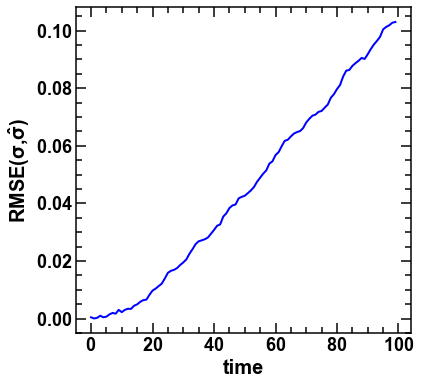

In [36]:
plt.clf()
plt.plot(jnp.sqrt(jnp.square(std0 - std1)))
plt.xlabel('time')
plt.ylabel('RMSE($\sigma$,$\hat{\sigma}$)')
plt.savefig(_filename('rmse(var).png'))

=== ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/rmse_mu.png ===


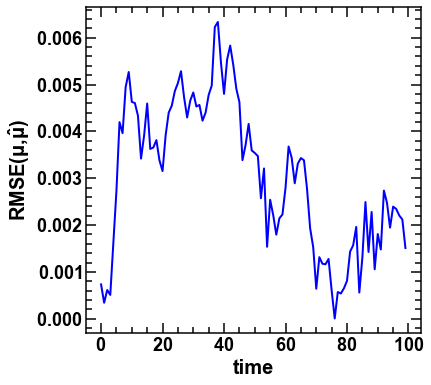

In [41]:
plt.clf()
plt.plot(jnp.sqrt(jnp.square(mu0 - mu1)))
plt.xlabel('time')
plt.ylabel('RMSE($\mu$,$\hat{\mu}$)')
plt.savefig(_filename('rmse_mu.png'))

=== ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/rmse_var.png ===


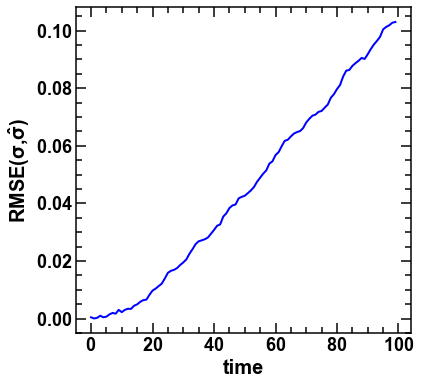

In [42]:
plt.clf()
plt.plot(jnp.sqrt(jnp.square(std0 - std1)))
plt.xlabel('time')
plt.ylabel('RMSE($\sigma$,$\hat{\sigma}$)')
plt.savefig(_filename('rmse_var.png'))

In [64]:
jnp.array(nexp['z_actual']).shape, jnp.array(nexp['z_pred']).shape, jnp.array(nexp['_gamma']).shape

((1000, 100, 5, 2), (1000, 100, 5, 2), (1, 5, 1))

In [81]:
_gamma = jnp.array(nexp['_gamma'])
disp = displacement(jnp.array(nexp['z_actual']), jnp.array(nexp['z_pred']))
dist_matrix = jnp.sqrt(jnp.square(disp).sum(-1))
dist_mean = jnp.mean(dist_matrix, axis=(0,2))
dist_by_gamma = dist_mean*_gamma[0]

=== ../results/a-5-Spring-data-brownian_EM-5BMCGNN/0/2nd_loass_term.png ===


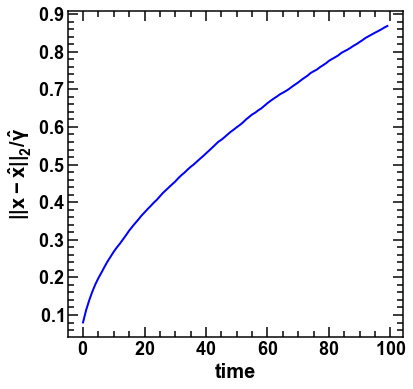

In [90]:
plt.clf()
plt.plot(dist_by_gamma)
plt.xlabel('time')
plt.ylabel('$||x-\hat{x}||_2$/$\hat{\gamma}$')
plt.savefig(_filename('2nd_loass_term.png'))